# ML Insights : Performance Metrics For Classification Models

## Use Case  

This Notebook shows how to configure following Classification Metrics using ML Insights .

- AccuracyScore , PrecisionScore , RecallScore , FBetaScore , FalsePositiveRate , FalseNegativeRate, Specificity , ConfusionMatrix , LogLoss , ROCCurve , ROCAreaUnderCurve , PrecisionRecallCurve , PrecisionRecallAreaUnderCurve 

## Note

- Performance Metrics For classsification Models works only for categorical type input features
- Confusion Matrix will work for following 
    - Binary class
    - Multi-class
    - Support only upto 256 labels
- Aggregate metrics 
    - Accuracy
    - Precision (Micro, Macro, Weighted)
    - Recall (Micro, Macro, Weighted)
    - F-beta score (Micro, Macro, Weighted) 
    - beta = 1
    - False Positive Rate works only for binary classification
    - False Negative Rate works only for binary classification
    - Specificity works only for binary classification
    - Log Loss require a feature in dataset which has Column Type as Prediction score
- Curves (Only for binary classification)
    - ROC Curve works only for binary classification
    - ROC- AUC works only for binary classification
    - Precision-Recall curve works only for binary classification
    - Precision-Recall curve / AUC works only for binary classification
- Performance metrics for classsification models needs to have target and prediction features in feature schema. This includes:
    - Column Type as Target for ground truth column , If these columns are missing or not configured, Insights throw validation errors
    - Column Type as Prediction for prediction column , If these columns are missing or not configured, Insights throw validation errors
    - Prediction score option in Column Type 

### About Dataset
The data was collected and made available by “National Institute of Diabetes and Digestive and Kidney Diseases” as part of the Pima Indians Diabetes Database. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here belong to the Pima Indian heritage (subgroup of Native Americans), and are females of ages 21 and above.

The data set contains medical and demographic data of patients . It consists of various features such as Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome, Prediction, BMICategory, Prediction_Score .

Dataset source : https://www.kaggle.com/datasets/kandij/diabetes-dataset



# Install ML Observability Insights Library SDK

- Prerequisites
    - Linux/Mac (Intel CPU)
    - Python 3.8 and 3.9 only


- Installation
    - ML Insights is made available as a Python package (via Artifactory) which can be installed using pip install as shown below. Depending on the execution engine on which to do the run, one can use scoped package. For eg: if we want to run on dask, use oracle-ml-insights[dask], for spark use oracle-ml-insights[spark], for native use oracle-ml-insights. One can install all the dependencies as use oracle-ml-insights[all]

      !pip install oracle-ml-insights

Refer : [Installation and Setup](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/tutorials/install.html)

In [ ]:
!python3 -m pip install oracle-ml-insights

In [ ]:
!python3 -m pip install matplotlib

# 1 ML Insights Imports 

In [18]:
# imports

import os
from typing import Any
import pyarrow as pa
import pandas as pd
import json


# Import metrics
from mlm_insights.core.metrics.count import Count
from mlm_insights.core.metrics.distinct_count import DistinctCount
from mlm_insights.core.metrics.duplicate_count import DuplicateCount
from mlm_insights.core.metrics.rows_count import RowCount

# Import Classification metrics
from mlm_insights.core.metrics.classification_metrics.accuracy_score import AccuracyScore
from mlm_insights.core.metrics.classification_metrics.recall_score import RecallScore
from mlm_insights.core.metrics.classification_metrics.precision_score import PrecisionScore
from mlm_insights.core.metrics.classification_metrics.confusion_matrix import ConfusionMatrix
from mlm_insights.core.metrics.classification_metrics.false_negative_rate import FalseNegativeRate
from mlm_insights.core.metrics.classification_metrics.false_positive_rate import FalsePositiveRate
from mlm_insights.core.metrics.classification_metrics.fbeta_score import FBetaScore
from mlm_insights.core.metrics.classification_metrics.specificity import Specificity
from mlm_insights.core.metrics.classification_metrics.log_loss import LogLoss
from mlm_insights.core.metrics.classification_metrics.roc import ROCCurve
from mlm_insights.core.metrics.classification_metrics.roc_auc import ROCAreaUnderCurve
from mlm_insights.core.metrics.classification_metrics.precision_recall_auc import PrecisionRecallAreaUnderCurve
from mlm_insights.core.metrics.classification_metrics.precision_recall_curve import PrecisionRecallCurve


from mlm_insights.builder.builder_component import MetricDetail, EngineDetail
from mlm_insights.constants.types import FeatureType, DataType, VariableType, ColumnType
from mlm_insights.core.metrics.metric_metadata import MetricMetadata
from mlm_insights.builder.insights_builder import InsightsBuilder
from mlm_insights.core.post_processors.local_writer_post_processor import LocalWriterPostProcessor


# import data reader
from mlm_insights.core.data_sources import LocalDatePrefixDataSource
from mlm_insights.mlm_native.readers import CSVNativeDataReader

import matplotlib.pyplot as plt

# 2 Configure Feature schema

Feature Schema defines the structure and metadata of the input data, which includes data type, column type, column mapping . The framework, uses this information as the ground truth and any deviation in the actual data is taken as an anomaly and the framework usually will ignore such all such anomaly in data.

In [19]:
def get_input_schema():
    return {
        "Pregnancies": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BloodPressure": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "SkinThickness": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Insulin": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "BMI": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Age": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "DiabetesPedigreeFunction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS),
        "Outcome": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.TARGET),
        "Prediction": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.PREDICTION),
        "Prediction_Score": FeatureType(data_type=DataType.FLOAT, variable_type=VariableType.CONTINUOUS,column_type = ColumnType.PREDICTION_SCORE),
        "BMICategory":FeatureType(data_type=DataType.STRING, variable_type=VariableType.NOMINAL)
    }



# 3 Configure Metrics

Metrics are the core construct for the framework. This component is responsible for calculating all statistical metrics and algorithms. Metric components work based on the type of features (eg. input feature, output feature etc.) available, their data type (eg. int, float, string etc.) as well as additional context (e.g. if any previous computation is available to compare against). ML Insights provides commonly used metrics out of the box for different ML observability use cases.

Refer : [Metrics Component Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/metrics_component.html)



In [20]:
def get_metrics():
    metrics = [
               MetricMetadata(klass=DistinctCount),
               MetricMetadata(klass=DuplicateCount),
               MetricMetadata(klass=Count)
              ]
    uni_variate_metrics = {
        "BloodPressure": metrics,
        "BMI": metrics
    }
    metric_details = MetricDetail(univariate_metric=uni_variate_metrics,
                                  dataset_metrics=[MetricMetadata(klass=RowCount),
                                                   MetricMetadata(klass=AccuracyScore),
                                                   MetricMetadata(klass=RecallScore),
                                                   MetricMetadata(klass=PrecisionScore),
                                                   MetricMetadata(klass=ConfusionMatrix),
                                                   MetricMetadata(klass=FalsePositiveRate, config={'labels': [0]}),
                                                   MetricMetadata(klass=FalseNegativeRate, config={"labels": [1]}),
                                                   MetricMetadata(klass=FBetaScore),
                                                   MetricMetadata(klass=Specificity, config={'labels': [1]}),
                                                   MetricMetadata(klass=ConfusionMatrix),
                                                   MetricMetadata(klass=ROCCurve ,config={"positive_label": 1}),
                                                   MetricMetadata(klass=ROCAreaUnderCurve , config={"positive_label": 1}),
                                                   MetricMetadata(klass=LogLoss , config={'labels': [1]}),
                                                   MetricMetadata(klass=PrecisionRecallCurve, config={"positive_label": 1})])
    return metric_details

# 4 Configure Data Reader

Data Reader allows for ingestion of raw data into the framework. This component is primarily responsible for understanding different formats of data (e.g. jsonl, csv) etc. and how to properly read them. At its essence, the primary responsibility of this component is that given a set of valid file locations which represents file of a specific type, reader can properly decode the content and load them in memory.

Additionally, Data Source component is an optional subcomponent, which is usually used along side the Reader. The primary responsibility of the data source component is to embed logic on filtering and partitioning of files to be read by the framework.

Refer : [Data Reader Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/data_reader_component.html)

In [21]:
def get_data_reader(start_date, end_date):
    
    # Define Data Format
    data = {
        "file_type": "csv",
        "date_range": {"start": start_date, "end": end_date}
    }
    
    # Define Data Location
    base_location ="input_data/diabetes_prediction"
    
    # Create new Dataset
    ds = LocalDatePrefixDataSource(base_location, **data)
    
    # Load Dataset
    csv_reader = CSVNativeDataReader(data_source=ds)
    
    
    return csv_reader

# 5 Compute the Profile 

Create the builder object which provides core set of api, using which user can set the behavior of their monitoring. By selecting what components and variants to run all aspects of the monitoring task can be customised and configured. 

The run() method is responsible to run the internal workflow. It also handles the life cycle of each component passed, which includes creation (if required), invoking interface functions, destroying etc . Additionally, runner also handles some more advanced operations like thread pooling, compute engine abstraction etc.

Refer : [Builder Object Documentation](https://docs.oracle.com/en-us/iaas/tools/ml-insights-docs/latest/ml-insights-documentation/html/user_guide/getting_started/builder_object.html)


In [22]:
# Create the ML Monitoring Metrics
def run_evaluation(start_date, end_date, output_location, output_file):    
    
    # Set up the insights builder by passing: input schema, metric, reader and engine details
    runner = InsightsBuilder(). \
        with_input_schema(get_input_schema()). \
        with_metrics(metrics=get_metrics()). \
        with_reader(reader=get_data_reader(start_date, end_date)). \
        with_post_processors(post_processors=[LocalWriterPostProcessor(file_location=output_location, file_name=output_file)]). \
        build()

    # Run the Evaluation of Metrics
    run_result = runner.run()
    
    return run_result.profile


In [23]:
# Define Baseline Dates
base_start_date = '2023-06-26'
base_end_date = '2023-06-29'

# Execute Profile - Pass in Data Start, Data End, Output Location, Output File
profile = run_evaluation(base_start_date, base_end_date, 'output_data/profiles', 'classification_metrics_profile.bin')

## 6 Profile Result

## 6.1 Visualize the Profile in tabular format

In [24]:
profile.to_pandas()

,Count.total_count,Count.missing_count,Count.missing_count_percentage,DistinctCount,DuplicateCount.count,DuplicateCount.percentage
BloodPressure,1686.0,0.0,0.0,47,1639,97.212337
BMI,1686.0,0.0,0.0,249,1437,85.231317


## 6.2 Visualize the Profile in JSON format

In [25]:

profile_json = profile.to_json()
dataset_metrics = profile_json['dataset_metrics']
# print(json.dumps(dataset_metrics,sort_keys=True, indent=4))

profile_json

{'dataset_metrics': {'LogLoss': {'metric_name': 'LogLoss',
   'metric_description': 'metric computes the Log loss. This is the loss function used in (multinomial) logistic regression, defined as the negative log-likelihood of a logistic model that returns y_pred probabilities for its training data y_true.The log loss is only defined for two or more labels.',
   'variable_count': 2,
   'variable_names': ['loss', 'normalized_loss'],
   'variable_types': ['CONTINUOUS', 'CONTINUOUS'],
   'variable_dtypes': ['FLOAT', 'FLOAT'],
   'variable_dimensions': [0, 0],
   'metric_data': [42233.25120756053, 25.04937794042736],
   'metadata': {}},
  'RecallScore': {'metric_name': 'RecallScore',
   'metric_description': 'Metric computes the recall.Recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives.The recall is intuitively the ability of the classifier to find all the positive samples',
   'variable_count': 5,
   'variable_names': ['macro', 

In [26]:
pd.json_normalize(dataset_metrics).T.dropna()

,0
LogLoss.metric_name,LogLoss
LogLoss.metric_description,metric computes the Log loss. This is the loss...
LogLoss.variable_count,2
LogLoss.variable_names,"[loss, normalized_loss]"
LogLoss.variable_types,"[CONTINUOUS, CONTINUOUS]"
...,...
PrecisionScore.variable_names,"[macro, micro, weighted, ovr, labels]"
PrecisionScore.variable_types,"[CONTINUOUS, CONTINUOUS, CONTINUOUS, CONTINUOU..."
PrecisionScore.variable_dtypes,"[FLOAT, FLOAT, FLOAT, FLOAT, STRING]"
PrecisionScore.variable_dimensions,"[0, 0, 0, 1, 1]"


## 6.3 Confusion matrix

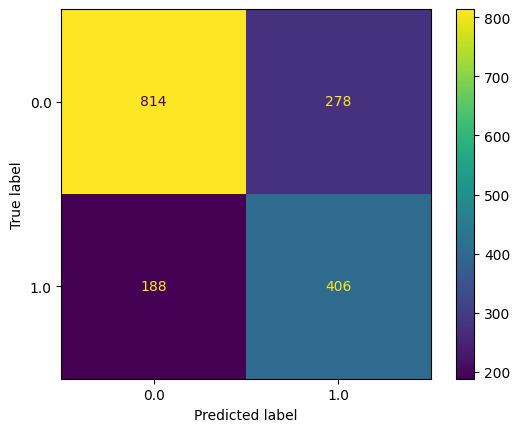

In [27]:


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cm_metric_result = dataset_metrics["ConfusionMatrix"]["metric_data"]
matrix = cm_metric_result[0]
labels = cm_metric_result[1]

numpyArrayMatrix = np.array(matrix)
numpyArrayLabel = np.array(labels)


disp = ConfusionMatrixDisplay(confusion_matrix=numpyArrayMatrix,
                              display_labels=numpyArrayLabel)

disp.plot()

plt.show()

## 6.4 ROC Curve

In [28]:
roc_fpr = dataset_metrics["ROCCurve"]["metric_data"][0]
roc_tpr = dataset_metrics["ROCCurve"]["metric_data"][1]
roc_thresholds	 = dataset_metrics["ROCCurve"]["metric_data"][2]

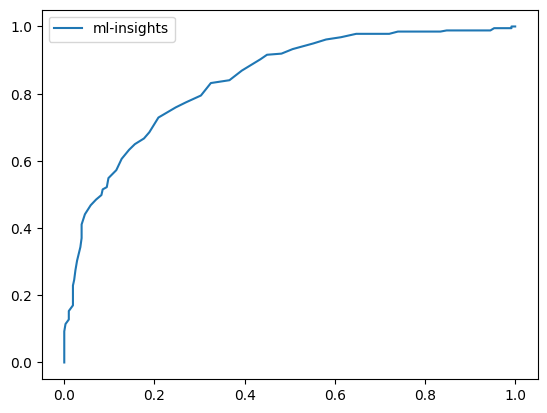

In [29]:
plt.plot(roc_fpr, roc_tpr, label="ml-insights")
plt.legend()
plt.show()

In [30]:
# Area under the curve 
ROCAreaUnderCurve = dataset_metrics["ROCAreaUnderCurve"]["metric_data"][0]
ROCAreaUnderCurve

0.840260048593382